In [1]:
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as stm
from statsmodels.tsa.stattools import adfuller

Loading data:

In [2]:
df = pd.read_csv("energy_demand_hourly_brazil.csv")

df.head(5)

,index,hourly_demand
0,2000-01-01 00:00:00,34673.9
1,2000-01-01 01:00:00,33503.0
2,2000-01-01 02:00:00,32287.6
3,2000-01-01 03:00:00,31059.4
4,2000-01-01 04:00:00,30272.7


In [3]:
df.tail(5)

,index,hourly_demand
201313,2022-12-31 20:00:00,75825.344
201314,2022-12-31 21:00:00,69894.955
201315,2022-12-31 22:00:00,64612.355
201316,2022-12-31 23:00:00,61215.376
201317,2023-01-01 00:00:00,58900.643


We are going to use only 1000 days of observation for the sake of computing time:

In [4]:
n = 24*1000
h = df.head(n)["hourly_demand"]
data = h.values

Vizualization of first 30 days of observation:

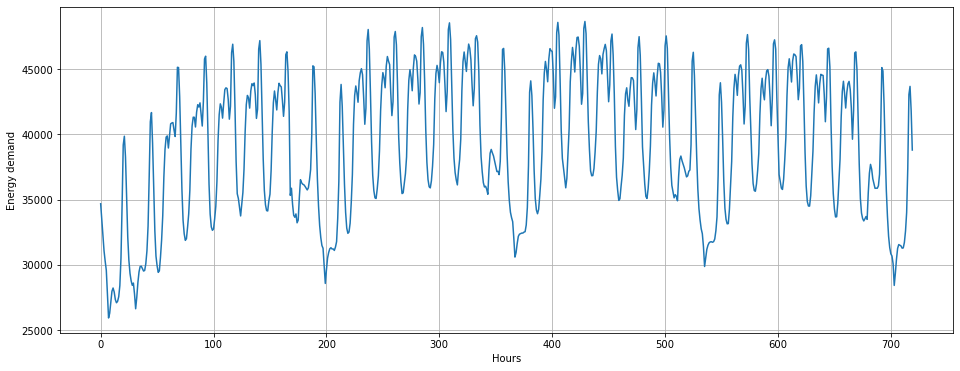

In [5]:
plt.figure(figsize = (16,6))
plt.plot(data[:24*30])
plt.xlabel("Hours")
plt.ylabel("Energy demand")
plt.grid()
plt.show()

Standardizing the data to feed to RNN:

In [6]:
X = data.reshape(-1,1)

scaler = StandardScaler()

scaler.fit(X)
X_sc = scaler.transform(X)

X = X_sc.reshape(1,-1)

X = X[0]

Creating train and test sets. The RNN will be predicting one observation given past 24h.

In [7]:
input_data = X[:-24]
targets = X[24:]
dataset_train = keras.utils.timeseries_dataset_from_array(
    input_data, targets, sequence_length=24, batch_size = 16, end_index = n - 1 - 24*24)

dataset_test = keras.utils.timeseries_dataset_from_array(
    input_data, targets, sequence_length=24, batch_size = 16, start_index = n - 1 - 25*24 + 1)

Setting up RNN using LSTM:

In [8]:
inputs = keras.layers.Input(shape=(24, 1))
lstm_out = keras.layers.LSTM(512)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.compile(optimizer='adam',
              loss=keras.losses.MeanSquaredError(),
              metrics=['MSE'])

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 24, 1)]           0         
                                                                 
 lstm (LSTM)                 (None, 512)               1052672   
                                                                 
 dense (Dense)               (None, 1)                 513       
                                                                 
Total params: 1,053,185
Trainable params: 1,053,185
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.fit(dataset_train, epochs = 10, validation_data=dataset_test)

Epoch 1/10
1463/1463 [==============================] - 64s 43ms/step - loss: 0.0602 - MSE: 0.0602 - val_loss: 0.0129 - val_MSE: 0.0129
Epoch 2/10
1463/1463 [==============================] - 61s 42ms/step - loss: 0.0192 - MSE: 0.0192 - val_loss: 0.0251 - val_MSE: 0.0251
Epoch 3/10
1463/1463 [==============================] - 59s 40ms/step - loss: 0.0123 - MSE: 0.0123 - val_loss: 0.0100 - val_MSE: 0.0100
Epoch 4/10
1463/1463 [==============================] - 62s 42ms/step - loss: 0.0099 - MSE: 0.0099 - val_loss: 0.0079 - val_MSE: 0.0079
Epoch 5/10
1463/1463 [==============================] - 63s 43ms/step - loss: 0.0087 - MSE: 0.0087 - val_loss: 0.0089 - val_MSE: 0.0089
Epoch 6/10
1463/1463 [==============================] - 61s 42ms/step - loss: 0.0075 - MSE: 0.0075 - val_loss: 0.0078 - val_MSE: 0.0078
Epoch 7/10
1463/1463 [==============================] - 61s 41ms/step - loss: 0.0070 - MSE: 0.0070 - val_loss: 0.0046 - val_MSE: 0.0046
Epoch 8/10
1463/1463 [==========================

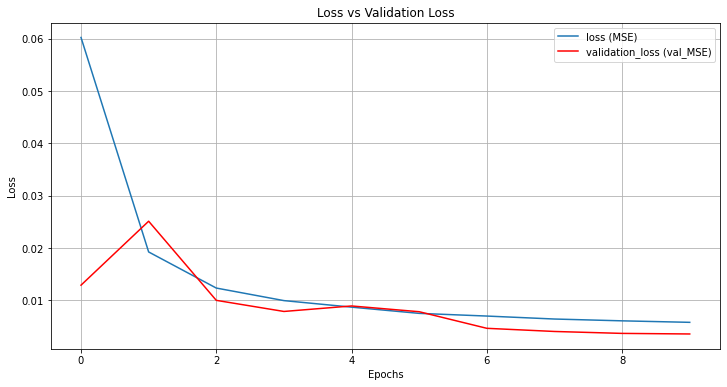

In [12]:
loss = model.history.history["loss"]
val_loss = model.history.history["val_loss"]
ep = range(len(loss))

plt.figure(figsize = (12,6))
plt.plot(ep,loss, label = "loss (MSE)")
plt.plot(ep,val_loss, label = "validation_loss (val_MSE)", color = 'red')
plt.title("Loss vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.legend()
plt.show()

As we can see network is not overfitting due to validation MSE getting lower. Next we make prediction for the whole test set. It is important to note that we are going to predict new values given true values from past 24h.

In [13]:
y = model.predict(dataset_test)

35/35 [==============================] - 1s 9ms/step


In [14]:
inputd = X[-2*24:]
target = np.zeros(24)
pred = keras.utils.timeseries_dataset_from_array(
    inputd, target, sequence_length=24, batch_size = 1)

In [15]:
y1 = model.predict(pred)

24/24 [==============================] - 0s 4ms/step


Plotting our prediction with MAE, RMSE and R2 metrics:

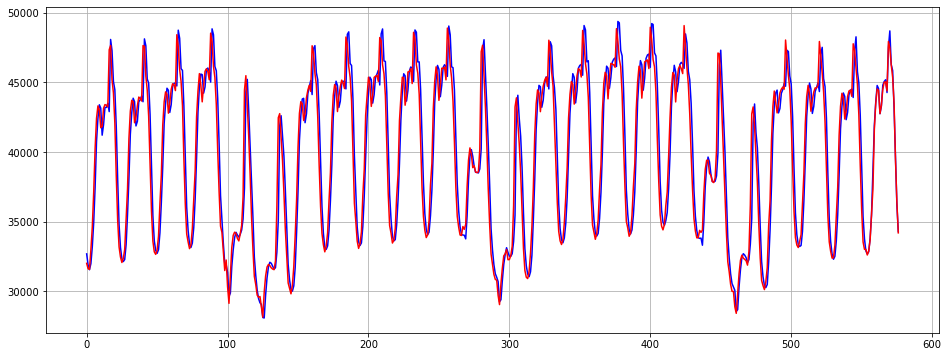

RMSE: 1874.7733331158204
MAE: 1414.5711674049567


In [16]:
Y = np.concatenate((scaler.inverse_transform(y).reshape(1,-1)[0], scaler.inverse_transform(y1).reshape(1,-1)[0]), axis=None)

plt.figure(figsize = (16,6))
plt.plot(data[n - 24*24-1:], color = "blue")
plt.plot(Y, color = "red")
plt.grid()
plt.show()
print("RMSE:",np.sqrt(mean_squared_error(Y, data[n - 24*24-1:])))
print("MAE:",mean_absolute_error(Y, data[n - 24*24-1:]))

Lets see how our model will perform in more practical setting. We are going to make a prediction for next 4 days given only 24h of true data. Any predicted data will be used for further prediction.

In [17]:
def further_prediciton(inputd, target, n):
    
    inputd = np.asarray(inputd, dtype = "float64")
    
    w = np.zeros(n)
    for i in range(n):
    
        dataset = keras.utils.timeseries_dataset_from_array(
                inputd, target, sequence_length=24, batch_size = 1)
        
        y = model.predict(dataset)
        w[i] = y
        
        inputd = np.asarray(np.concatenate((inputd[1:],y.reshape(-1,1)[0] ), axis = None), dtype = "float64")
        
        target = np.array([0.0])
    
    return w
    

In [18]:
m = 4*24
y = further_prediciton(X[-24:], np.array([0.0]), m)

1/1 [==============================] - 0s 38ms/step


In [19]:
y_24 = scaler.inverse_transform( y.reshape(-1,1) ).reshape(1,-1)[0]

In [20]:
n = 24000 + m
h = df.head(n)["hourly_demand"]
data = h.values

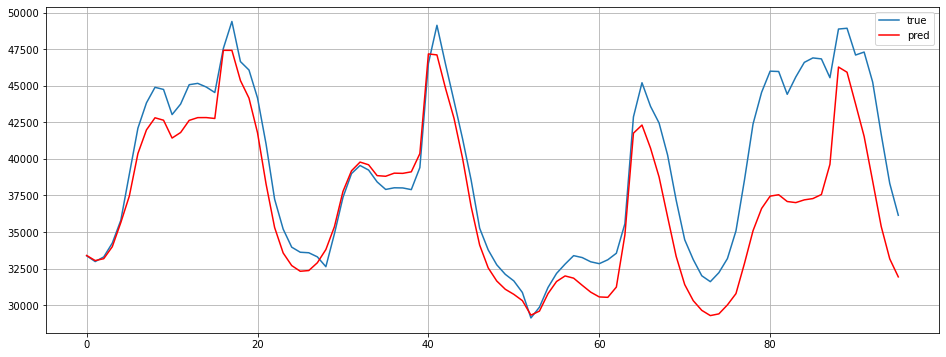

RMSE: 3496.257921084622
MAE: 2536.4645865115235


In [21]:
plt.figure(figsize = (16,6))
plt.plot(data[24000:], label = "true")
plt.plot(y_24, color = "red", label = "pred")
plt.legend()
plt.grid()
plt.show()
print("RMSE:", np.sqrt(mean_squared_error(y_24, data[24000:])))
print("MAE:",mean_absolute_error(y_24, data[24000:]))

As we can see the prediction is reasonable for the first 2 or 3 days, then it starts to be really inaccurate. In the next portion we will explore the classical solution for time series modeling -- SARIMA and compare the results.

Again let's plot the data (first 30 days):

In [22]:
n = 24*60
h = df.head(n)["hourly_demand"]
data = h.values

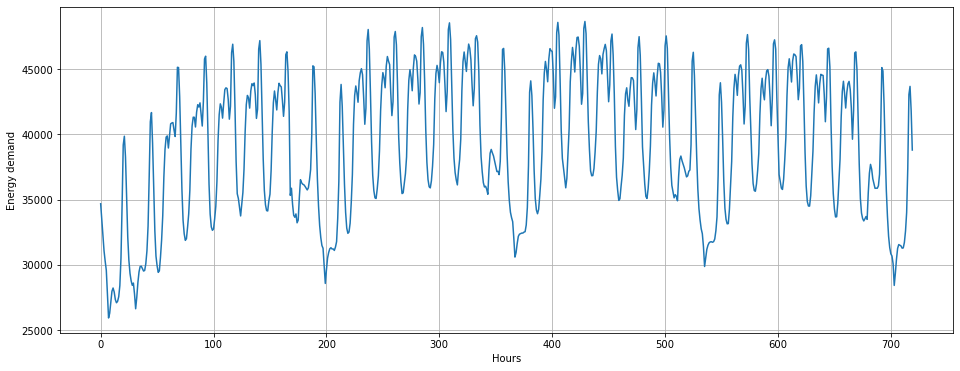

In [23]:
plt.figure(figsize = (16,6))
plt.xlabel("Hours")
plt.ylabel("Energy demand")
plt.plot(data[:24*30])
plt.grid()
plt.show()

Let's look at ACF and PACF graphs:

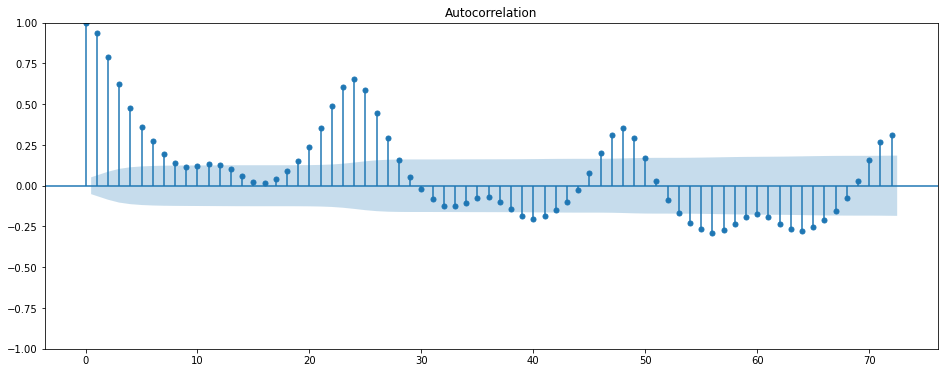

In [24]:
fig = stm.graphics.tsa.plot_acf(data, lags = 24*3)  # lags at most 3 days
fig.set_size_inches(16, 6)
plt.show()

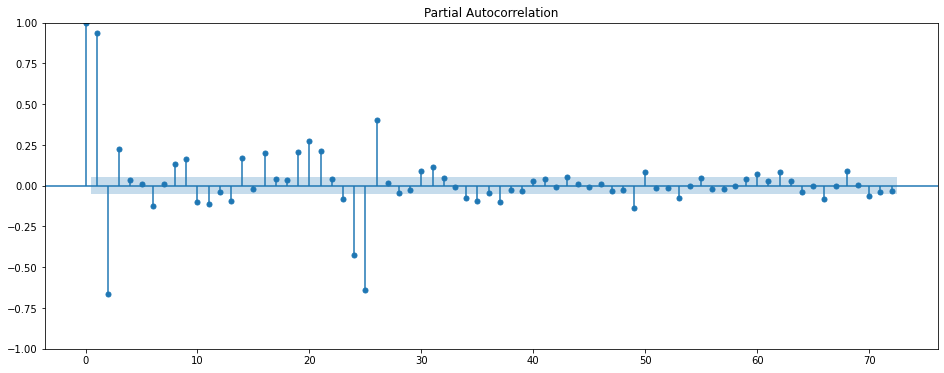

In [25]:
fig = stm.graphics.tsa.plot_pacf(data, lags = 24*3, method = 'ywm')  # lags at most 3 days
fig.set_size_inches(16, 6)
plt.show()

Differencing the data to get rid of the trend.

In [26]:
diff = h.diff()[1:]

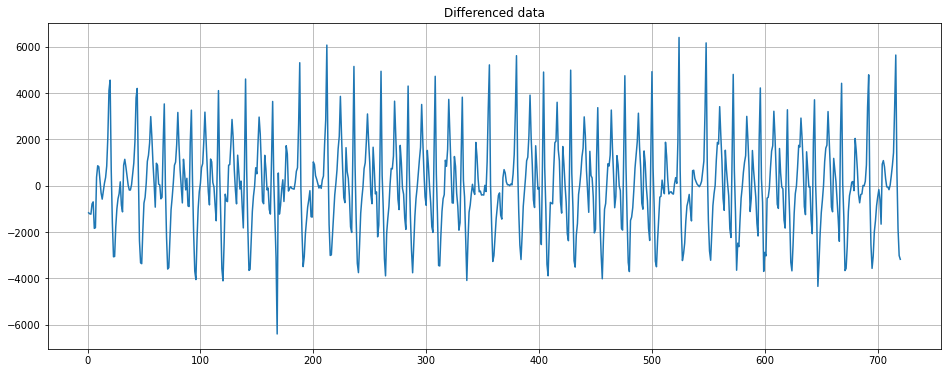

In [27]:
plt.figure(figsize = (16,6))
plt.plot(diff[:24*30])
plt.title("Differenced data")
plt.grid()
plt.show()

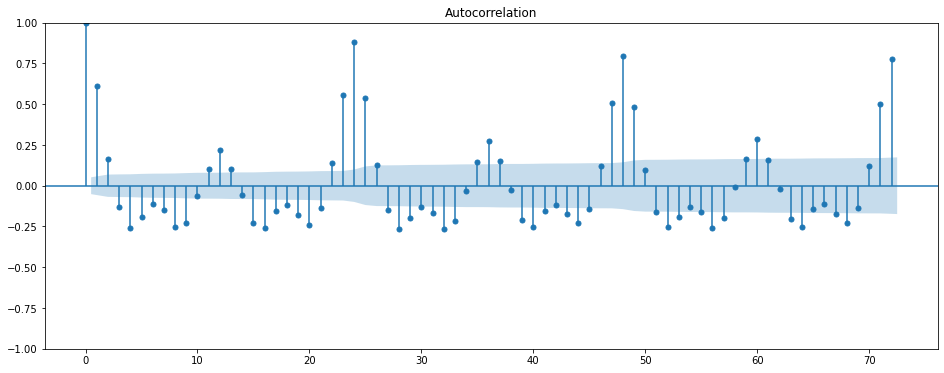

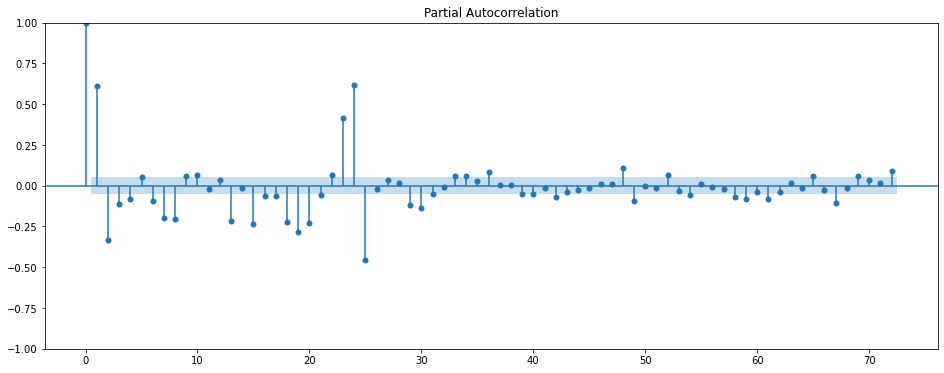

In [28]:
fig = stm.graphics.tsa.plot_acf(diff, lags = 24*3)  # lags at most 3 days
fig.set_size_inches(16, 6)
plt.show()
fig = stm.graphics.tsa.plot_pacf(diff, lags = 24*3, method = 'ywm')  # lags at most 3 days
fig.set_size_inches(16, 6)
plt.show()

Differencing to get rid of the seasonality.

In [29]:
diff_24 = diff.diff(periods = 24*7)[24*7:]

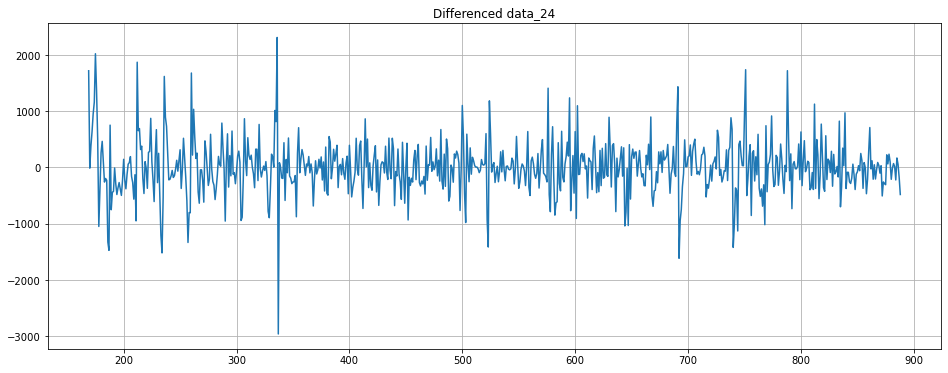

In [30]:
plt.figure(figsize = (16,6))
plt.plot(diff_24[:24*30])
plt.title("Differenced data_24*7")
plt.grid()
plt.show()

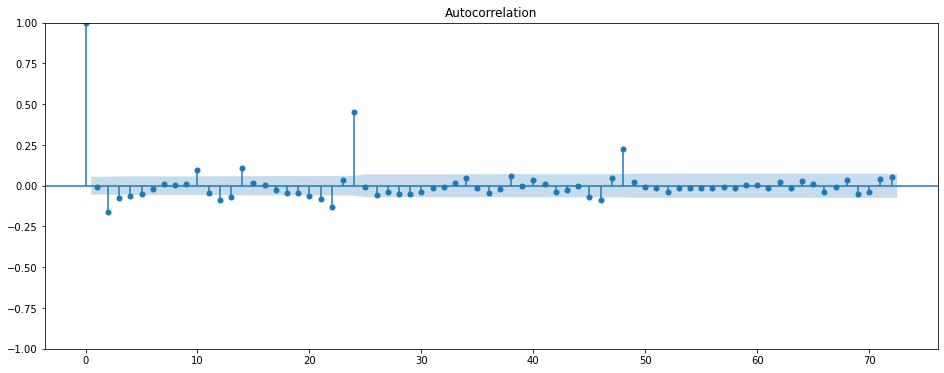

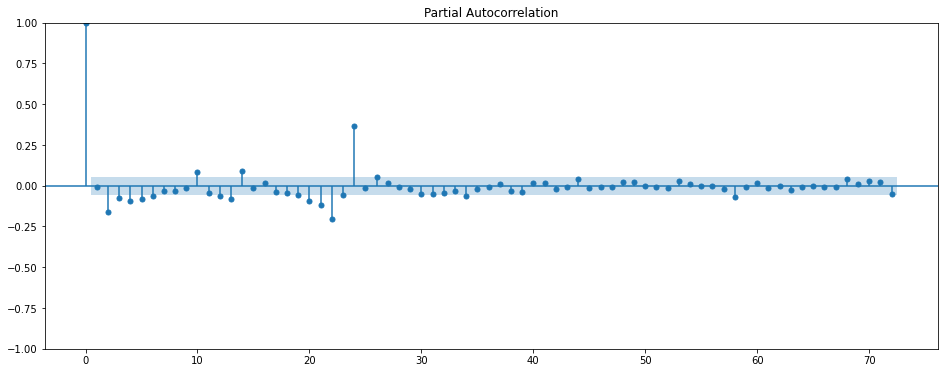

In [31]:
fig = stm.graphics.tsa.plot_acf(diff_24, lags = 24*3)  # lags at most 3 days
fig.set_size_inches(16, 6)
plt.show()
fig = stm.graphics.tsa.plot_pacf(diff_24, lags = 24*3, method = 'ywm')  # lags at most 3 days
fig.set_size_inches(16, 6)
plt.show()

In [32]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [33]:
model2 = SARIMAX(data, order = (0,1,0), seasonal_order = (0,1,1,24*7))

In [34]:
model2 = model2.fit()

In [35]:
print(model2.summary())
print(model2.aic)

                                       SARIMAX Results                                       
Dep. Variable:                                     y   No. Observations:                 1440
Model:             SARIMAX(0, 1, 0)x(0, 1, [1], 168)   Log Likelihood               -9872.649
Date:                               Fri, 17 Feb 2023   AIC                          19749.298
Time:                                       02:27:16   BIC                          19759.593
Sample:                                            0   HQIC                         19753.165
                                              - 1440                                         
Covariance Type:                                 opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L168     -0.2920      0.024    -12.260      0.000      -0.339      -0.245
sigma2     

In [36]:
m = 24*6
n = 24*60 + m
h = df.head(n)["hourly_demand"]
data = h.values

In [37]:
y_pred = model2.get_forecast(m)
y_CI = y_pred.conf_int(alpha = 0.05) 
y = model2.forecast(m)

In [38]:
y_CI_U = np.zeros(m)
y_CI_D = np.zeros(m)

for i in range(m):
    y_CI_U[i] = y_CI[i][1]
    y_CI_D[i] = y_CI[i][0]
    

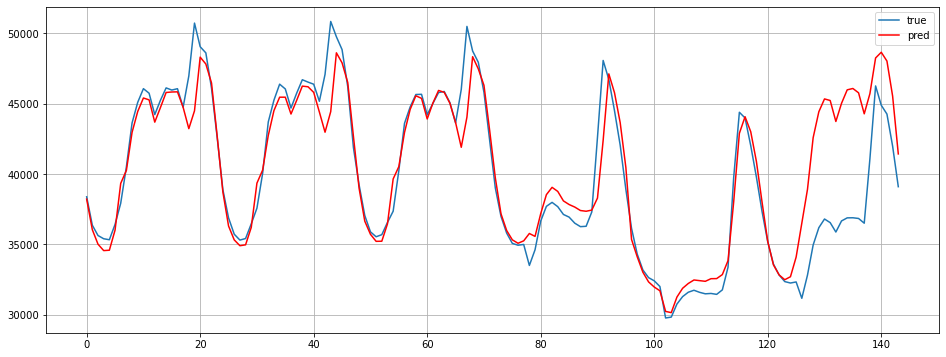

In [39]:
plt.figure(figsize = (16,6))
plt.plot(data[n - m:], label = "true")
plt.plot(y, color = "red", label = "pred")
plt.legend()
plt.grid()
plt.show()


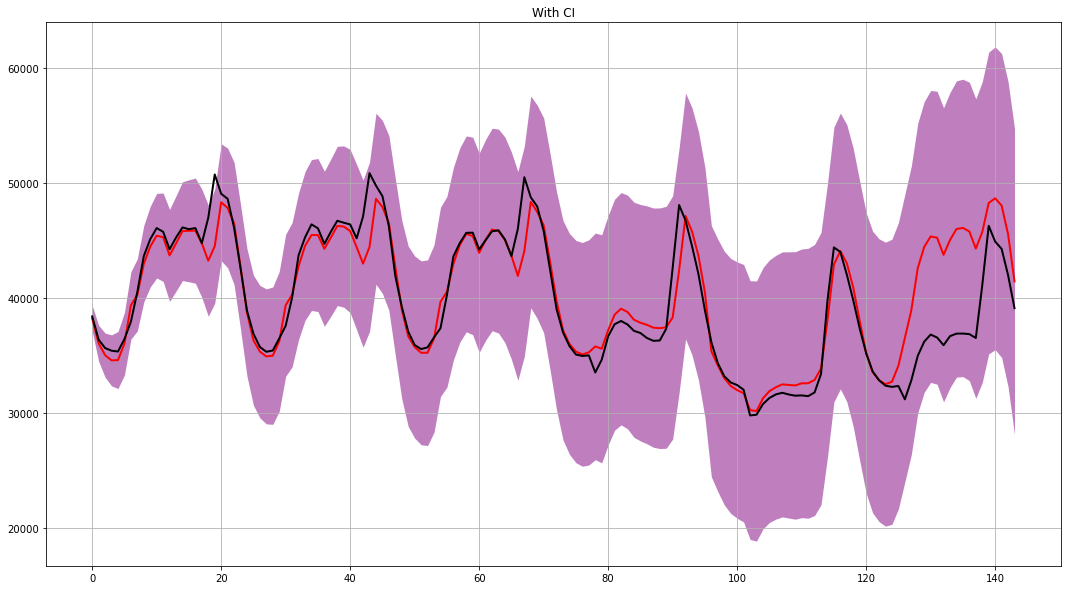

In [40]:
fig = plt.figure(figsize=(40, 10))

ax = fig.add_subplot(121)

ax.fill_between(range(m),y_CI_D, y_CI_U, alpha=.5, linewidth=0, color = 'purple')
ax.plot(range(m),y, linewidth=2, color = 'red')


ax.plot(range(m),data[n - m:], linewidth=2, color = 'black')

plt.title("With CI")
plt.grid()
plt.show()

In [41]:
print("RMSE:", np.sqrt(mean_squared_error(y, data[n - m:])))
print("MAE:",mean_absolute_error(y, data[n - m:]))

RMSE: 2812.343056143899
MAE: 1580.9634770389448


We can also try to use regression approach. To demonstrate this we will use randomforest.

We need to derive some features from our data. Natural choices are hours, days, months, years. From previous data visualisations it can be seen that demand is different for weekends than work days.

In [42]:
df_date = pd.read_csv("energy_demand_hourly_brazil.csv", index_col = "index", parse_dates = True)

In [43]:
df_date['hour'] = df_date.index.hour
df_date['day'] = df_date.index.day
df_date['month'] = df_date.index.month
df_date['year'] = df_date.index.year
df_date['day_num'] = df_date.index.day_of_week #important to know whether its weekend or work day

df_date

,hourly_demand,hour,day,month,year,day_num
index,,,,,,
2000-01-01 00:00:00,34673.900,0,1,1,2000,5
2000-01-01 01:00:00,33503.000,1,1,1,2000,5
2000-01-01 02:00:00,32287.600,2,1,1,2000,5
2000-01-01 03:00:00,31059.400,3,1,1,2000,5
2000-01-01 04:00:00,30272.700,4,1,1,2000,5
...,...,...,...,...,...,...
2022-12-31 20:00:00,75825.344,20,31,12,2022,5
2022-12-31 21:00:00,69894.955,21,31,12,2022,5
2022-12-31 22:00:00,64612.355,22,31,12,2022,5


In [44]:
n = 24*60
m = 24*6
data = df_date.head(n+m)

In [45]:
X = data.drop(['hourly_demand'], axis = 1).values
y = data['hourly_demand'].values

X_train, X_test = X[:n], X[n:]
y_train, y_test = y[:n], y[n:]



In [46]:
from sklearn.ensemble import RandomForestRegressor

In [54]:
rf = RandomForestRegressor(n_estimators = 200, max_features = "sqrt")

In [55]:
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

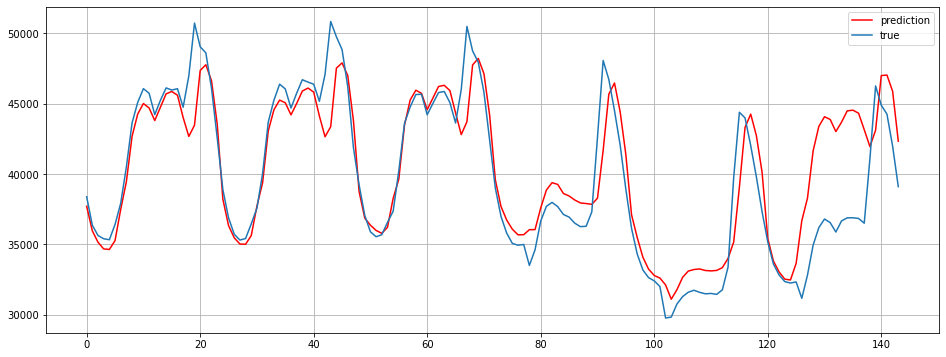

In [56]:
plt.figure(figsize = (16,6))
plt.plot(y_pred, label = 'prediction', color = 'red')
plt.plot(y_test, label = 'true')
plt.legend()
plt.grid()
plt.show()

In [50]:
print("RMSE:", np.sqrt(mean_squared_error(y_pred, y_test)))
print("MAE:",mean_absolute_error(y_pred, y_test))

RMSE: 2784.804610936909
MAE: 1829.1009500010357


Although SARIMA and random forest perform quite similarly, advantage of using SARIMA are confidence intervals that can be used to predict peaks of energy consumption. 

On the other hand using regression approach can be useful if we have additional data that can be used to make our prediciton better.